In [1]:
import pandas as pd
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib

from matplotlib import pyplot as plt
from copy import deepcopy
from scipy.ndimage.measurements import label

from code_base.utils import get_audio_path, milliseconds_2_points

%matplotlib inline

/tmp/ipykernel_2475630/29434539.py:9: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [2]:
MATPLOTLIB_COLORS = list(matplotlib.colors.BASE_COLORS.keys())[:-1] # exclude white

# Tabular Data

In [3]:
df = pd.read_csv("../data/processed/markup.csv")
df

,sample_name,spk_name,replica_start,replica_end
0,KB0RE000,PS002,0,2464
1,KB0RE000,PS006,2448,2688
2,KB0RE000,PS002,2688,3120
3,KB0RE000,PS006,3120,5056
4,KB0RE000,PS002,4880,5808
...,...,...,...,...
183120,KE6RE01R,PS0X9,889050,889570
183121,KE6RE01R,PS0X8,889570,904510
183122,KE6RE01R,PS0X9,904510,904600
183123,KE6RE01R,PS0X8,904600,923190


Number of episodes: 1588
Number of speakers: 520
Median number of speakers in episode: 2.0
Min number of speakers in episode: 1
Max number of speakers in episode: 13


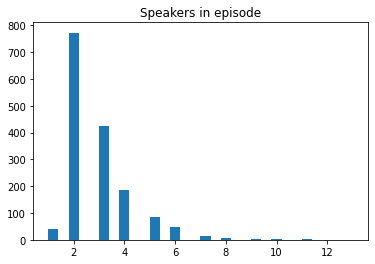

Min episode duration: 0.0015
Max episode duration: 47.038
Median episode duration: 3.185083333333333


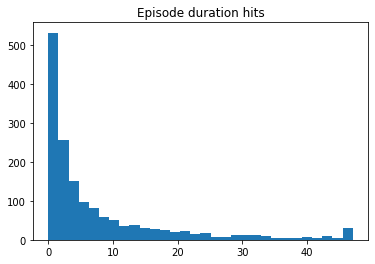

In [4]:
print(f"Number of episodes: {df['sample_name'].nunique()}")
print(f"Number of speakers: {df['spk_name'].nunique()}")

episode_speakers =  df.groupby('sample_name')['spk_name'].apply(np.unique)
episode_n_speakers = episode_speakers.apply(len)
print(f"Median number of speakers in episode: {episode_n_speakers.median()}")
print(f"Min number of speakers in episode: {episode_n_speakers.min()}")
print(f"Max number of speakers in episode: {episode_n_speakers.max()}")
plt.title("Speakers in episode")
plt.hist(episode_n_speakers, bins=30)
plt.show()

episode_durations = df.groupby('sample_name').apply(lambda x: (x['replica_end'].max() - x['replica_start'].min()) / (1000 * 60))
print(f"Min episode duration: {episode_durations.min()}")
print(f"Max episode duration: {episode_durations.max()}")
print(f"Median episode duration: {episode_durations.median()}")
plt.title("Episode duration hits")
plt.hist(episode_durations, bins=30)
plt.show()

## Data filtering

Lets filter some strange episodes in separate DF. We will define strange episodes as such, which:
- duration < 1 min
- n_speakers > 4

In [5]:
episode_meta_info = episode_speakers.reset_index().merge(
    episode_durations.reset_index().rename(columns={0:"duration"}), 
    on="sample_name"
)

episode_meta_info

,sample_name,spk_name,duration
0,KB0RE000,"[KB0PSUN, PS002, PS006]",6.562917
1,KB0RE001,"[KB0PSUN, PS005, PS007]",4.657333
2,KB0RE002,"[PS003, PS007]",3.199833
3,KB0RE003,"[PS006, PS007]",29.664500
4,KB0RE005,"[KB0PSUN, PS003, PS004, PS009, PS00A]",29.614667
...,...,...,...
1583,KE6RE01C,"[PS0X8, PS0X9]",1.302667
1584,KE6RE01D,"[PS0X8, PS0X9]",6.162333
1585,KE6RE01L,"[PS0X8, PS0X9]",4.769833
1586,KE6RE01N,"[PS0X8, PS0X9, PS0XA]",4.131500


In [6]:
strange_episodes = episode_meta_info.loc[(episode_meta_info["duration"] < 1) | (episode_meta_info["spk_name"].apply(len) > 4), "sample_name"].tolist()
good_episodes = list(set(episode_meta_info["sample_name"]) - set(strange_episodes))

print(f"Number of strange episodes: {len(strange_episodes)}")
print(f"Number of good episodes: {len(good_episodes)}")

print(f"Overall duration of strange episodes: {episode_meta_info.loc[episode_meta_info['sample_name'].isin(strange_episodes), 'duration'].sum()}")
print(f"Overall duration of good episodes: {episode_meta_info.loc[episode_meta_info['sample_name'].isin(good_episodes), 'duration'].sum()}")

Number of strange episodes: 540
Number of good episodes: 1048
Overall duration of strange episodes: 3399.9752833333337
Overall duration of good episodes: 9008.198983333332


In [8]:
filtered_df = df[df.sample_name.isin(good_episodes)]
filtered_df.to_csv("../data/processed/markup_filtered.csv", index=False)
filtered_df

,sample_name,spk_name,replica_start,replica_end
0,KB0RE000,PS002,0,2464
1,KB0RE000,PS006,2448,2688
2,KB0RE000,PS002,2688,3120
3,KB0RE000,PS006,3120,5056
4,KB0RE000,PS002,4880,5808
...,...,...,...,...
183120,KE6RE01R,PS0X9,889050,889570
183121,KE6RE01R,PS0X8,889570,904510
183122,KE6RE01R,PS0X9,904510,904600
183123,KE6RE01R,PS0X8,904600,923190


# Check audio samples

In [9]:
def get_spk_mask(input_df, input_au, input_sr, plot=True):
    unique_spks = input_df.spk_name.unique()
    spk2id = {spk:i for i,spk in enumerate(unique_spks)}
    au_mask = np.full(input_au.shape[0], -1)
      
    for start, end, spk in zip(input_df.replica_start, input_df.replica_end, input_df.spk_name):
        spk_id = spk2id[spk]
        au_mask[milliseconds_2_points(start, input_sr):milliseconds_2_points(end, input_sr)] = spk_id
                
    return au_mask, spk2id

def plot_masked_au(input_au, mask_au, input_spk2id):
    id2spk = {v:k for k,v in input_spk2id.items()}
    id2spk[-1] = "not_spk"
    x_axis = np.arange(len(input_au)) / (16_000 * 60)
    connected_comps, _ = label(mask_au+1)
    plotted_spks = []
    
    plt.figure(figsize=(30,10))
    plt.title("Masked Wave")
    for con_comp_id in np.unique(connected_comps):
        spk_id =  mask_au[connected_comps==con_comp_id][0]
        spk = id2spk[spk_id]
        plt.plot(
            x_axis[connected_comps==con_comp_id],
            input_au[connected_comps==con_comp_id],
            color=MATPLOTLIB_COLORS[spk_id],
            label=None if spk in plotted_spks else spk
        )
        plotted_spks.append(spk)
        
    plt.legend()
    plt.show()

In [10]:
episode_name = good_episodes[2]
episode_au, episode_sr = librosa.load(get_audio_path("../data/processed/audio/", episode_name), sr=None)

# ipd.Audio(data=episode_au, rate=episode_sr)

In [11]:
episode_df = df[df.sample_name == episode_name].reset_index(drop=True)
print(f"Episode speakers: {episode_df.spk_name.unique()}")
episode_df.head(5)

Episode speakers: ['PS05X' 'PS101']


,sample_name,spk_name,replica_start,replica_end
0,KBKRE037,PS05X,0,1400
1,KBKRE037,PS101,1400,8320
2,KBKRE037,PS05X,8320,9380
3,KBKRE037,PS101,9680,10060
4,KBKRE037,PS05X,10760,11370


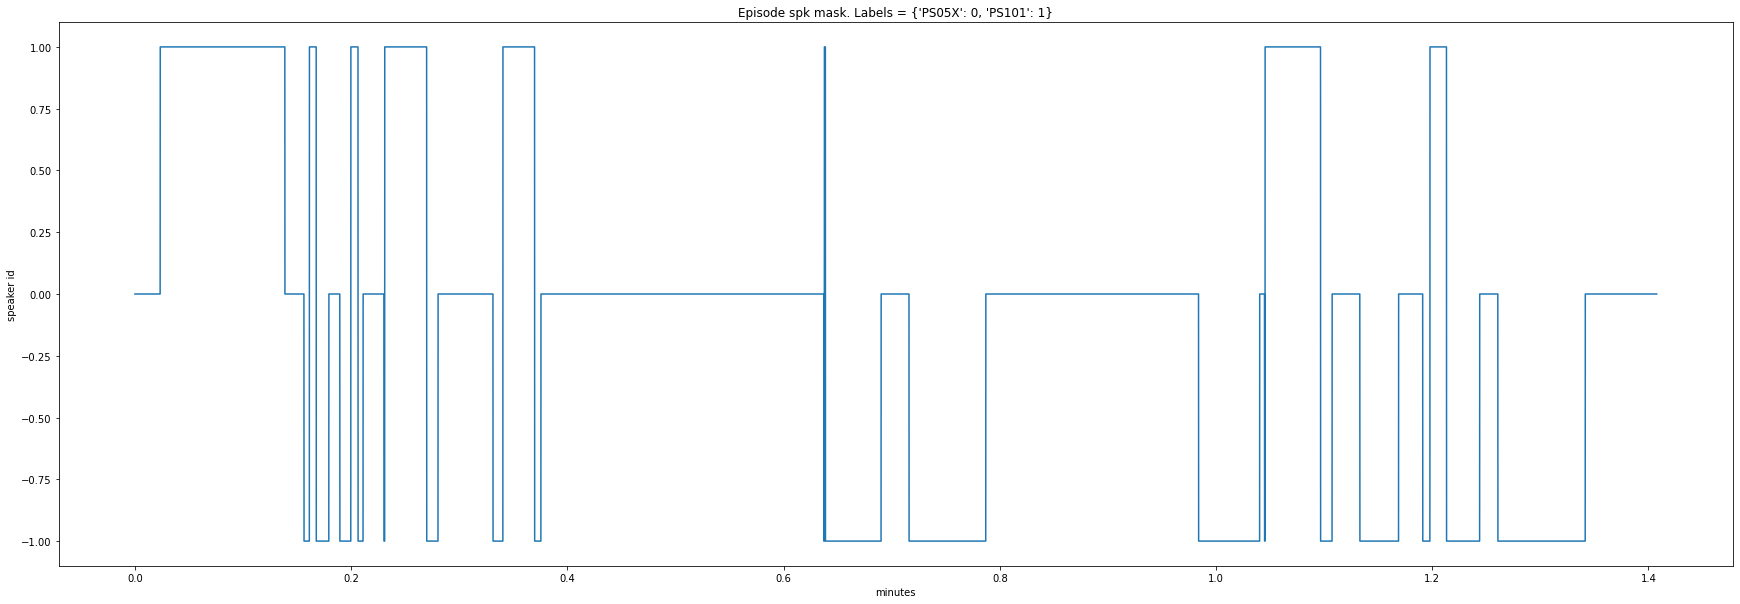

In [12]:
episode_mask, episode_spk2id = get_spk_mask(episode_df, episode_au, episode_sr)

plt.figure(figsize=(30,10))
plt.title(f"Episode spk mask. Labels = {episode_spk2id}")
plt.plot(np.arange(len(episode_mask)) / (16_000 * 60), episode_mask)
plt.xlabel("minutes")
plt.ylabel("speaker id")
plt.show()

In [13]:
# ipd.Audio(data=episode_au[episode_mask==episode_spk2id["PS04U"]], rate=episode_sr)

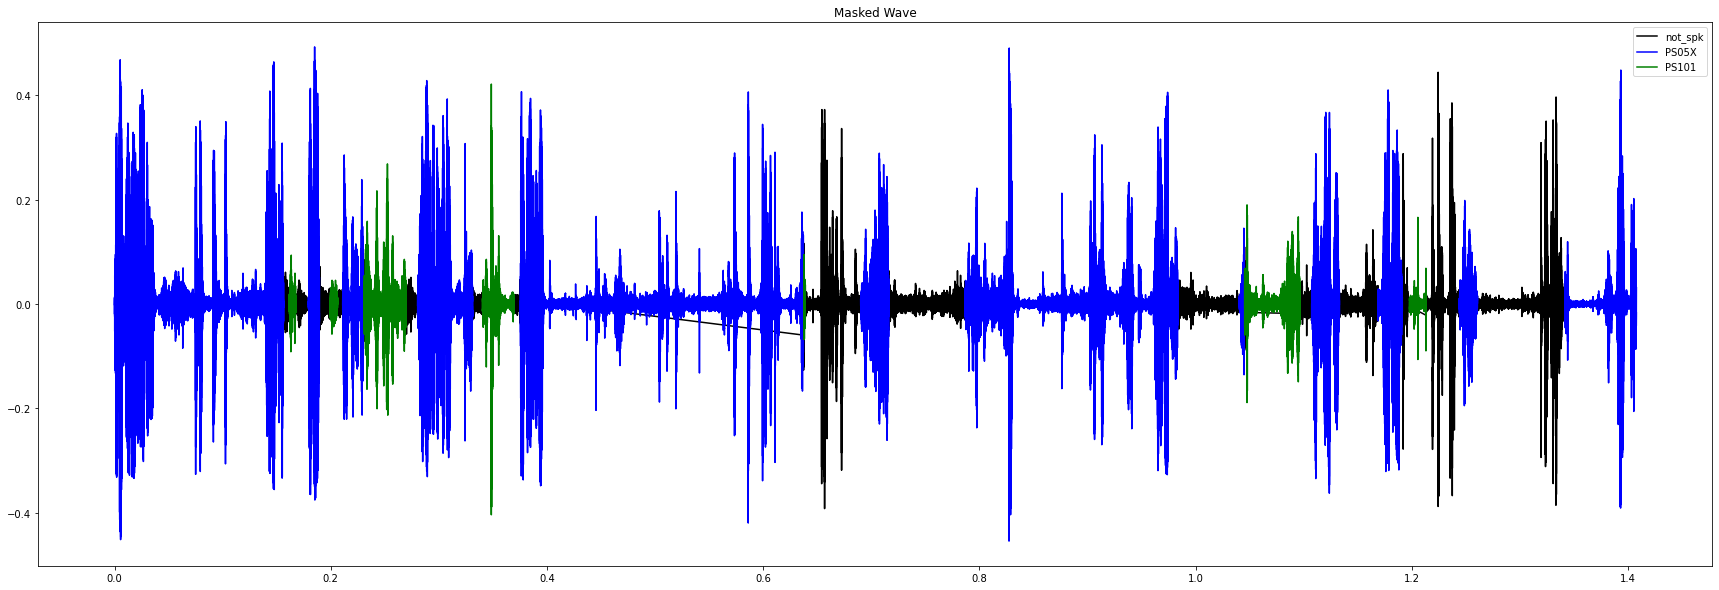

In [14]:
plot_masked_au(
    episode_au,
    episode_mask,
    episode_spk2id
)